In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#sys.path.append(str(Path(__file__).resolve().parent.parent))

from os import listdir
from os.path import isfile, join

import tensorflow as tf
import seaborn as sns

2025-11-07 16:21:48.563866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 16:21:48.574204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762528908.587715 1810850 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762528908.592237 1810850 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-07 16:21:48.605410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Define Data Directory and Batch size

In [3]:
num_classes = 126
batch_size = 32
spec_dir = '../data/image_data/'

## B - <a name="generateurs"></a> Data Generators



In [4]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )


- (d) Implement ```training_data```, ```valid_data``` splits


In [5]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)


Found 49204 images belonging to 126 classes.
Found 12242 images belonging to 126 classes.


# II - <a name="classif"></a> Class Distribution



In [6]:
# 1️⃣ Get class names and corresponding labels
class_indices = training_data.class_indices                # dict: {'class_name': index}
classes = list(class_indices.keys())                       # list of class names
labels = training_data.classes                             # array of integers (length = n_samples)

In [7]:
#class_indices

In [10]:
# 1️⃣ Build a DataFrame of class counts
counts = pd.Series(labels).value_counts().rename_axis("class_idx").reset_index(name="count")
idx_to_class = {v: k for k, v in class_indices.items()}
counts["class_name"] = counts["class_idx"].map(idx_to_class)


# III - <a name="classif"></a> Plot Accuracy vs Sample size

In [11]:
exp_no=2 # needs to berelated to one of the ready runs, for whic there is already config file and validation metrics
#project_root = Path().resolve().parent
project_root = Path(str(Path().resolve().parent))
metrics_save_path = project_root / "results" / "metrics"
per_class_accuracy = np.load(metrics_save_path / f"Exp{exp_no}_per_class_accuracy.npy")

In [12]:
counts_by_classname = counts.sort_values(by="class_name", ascending=True)
counts_by_classname.head(3)

,class_idx,count,class_name
83,0,448,Adalia_bipunctata
121,1,30,Amegilla_atrocincta
29,2,480,Amphimallon_solstitiale


In [13]:
counts_by_classname["accuracy"] = per_class_accuracy

In [49]:
def plot_acc_vs_sample_size(df_sorted): 
    plt.figure(figsize=(18, 6))
    sns.set(style="whitegrid")

    # Bar plot
    bars = sns.barplot(
        x='class_name', 
        y='count', 
        data=df_sorted, 
        color='skyblue'
    )

    # Offset for label placement (for clarity)
    y_offset = 0.02 * df_sorted['count'].max()

    # Add accuracy text above each bar
    for i, row in enumerate(df_sorted.itertuples()):
        plt.text(
            i, 
            row.count + y_offset, 
            f"{row.accuracy:.2f}", 
            ha='center', 
            va='bottom', 
            fontsize=9, 
            color='black'
        )


    # Styling
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Class Name")
    plt.ylabel("Number of Samples")
    plt.ylim([0, 1.1 * np.max(df_sorted["count"])])
    plt.title("Sample Count with Per-Class Accuracy")
    plt.tight_layout()
    plt.show()

# Head side of the distribution

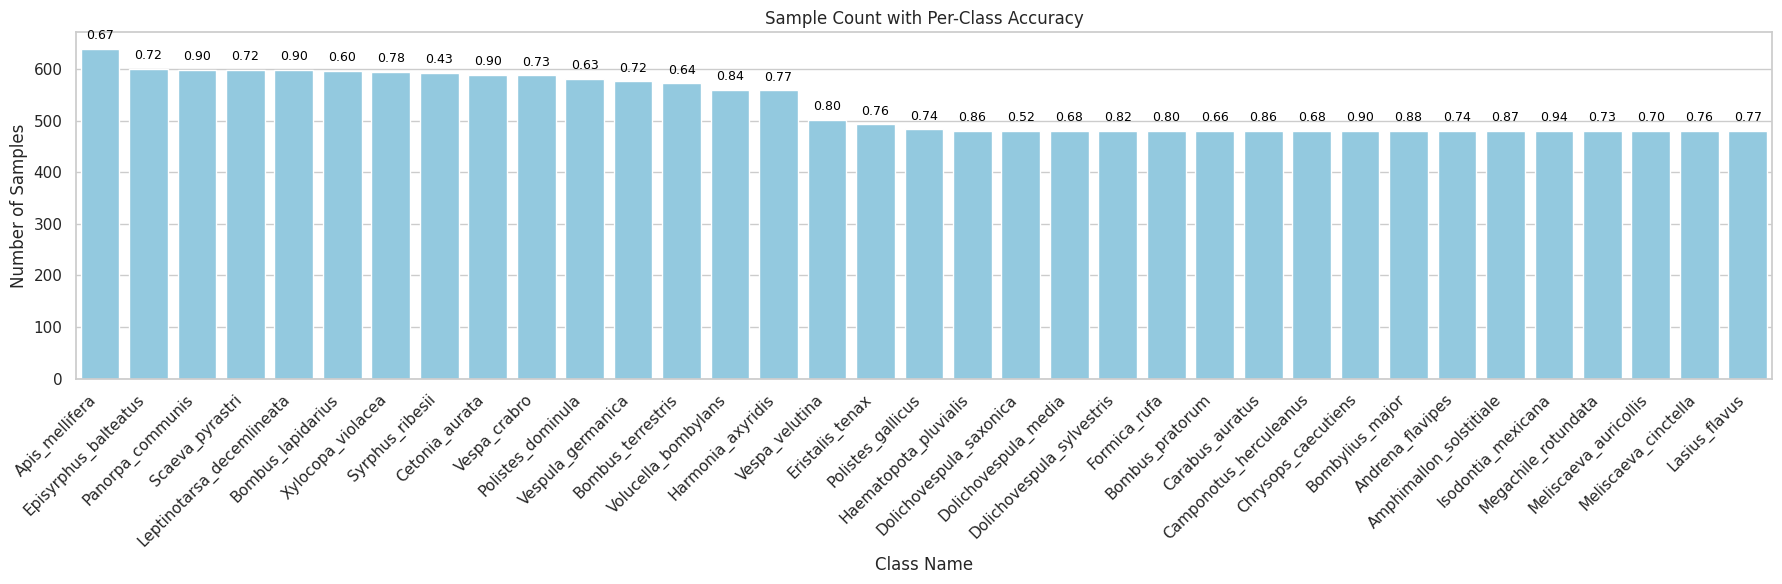

In [41]:
df_sorted = counts_by_classname.sort_values(by="count", ascending=False).head(35)
plot_acc_vs_sample_size(df_sorted)

# Tail of the distribution

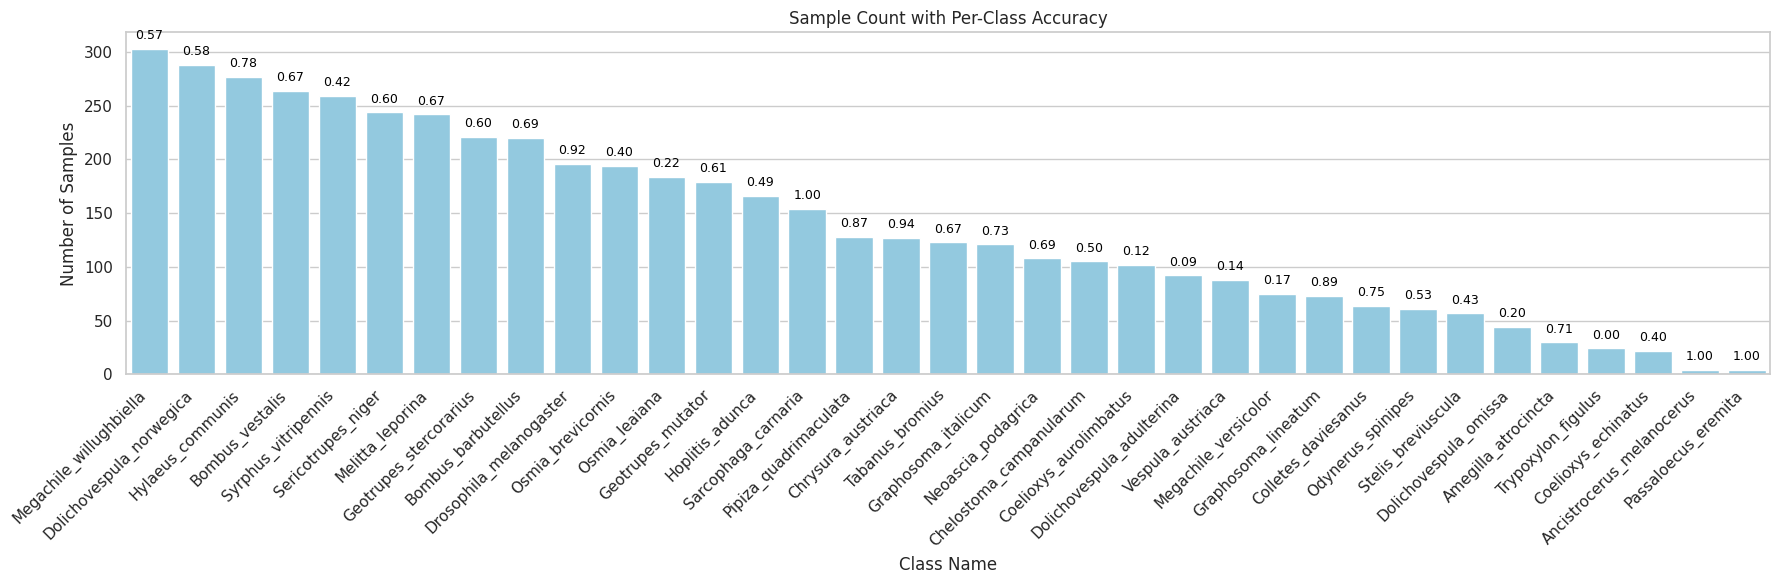

In [42]:
df_sorted = counts_by_classname.sort_values(by="count", ascending=False).tail(35)
plot_acc_vs_sample_size(df_sorted)

# Middle Part

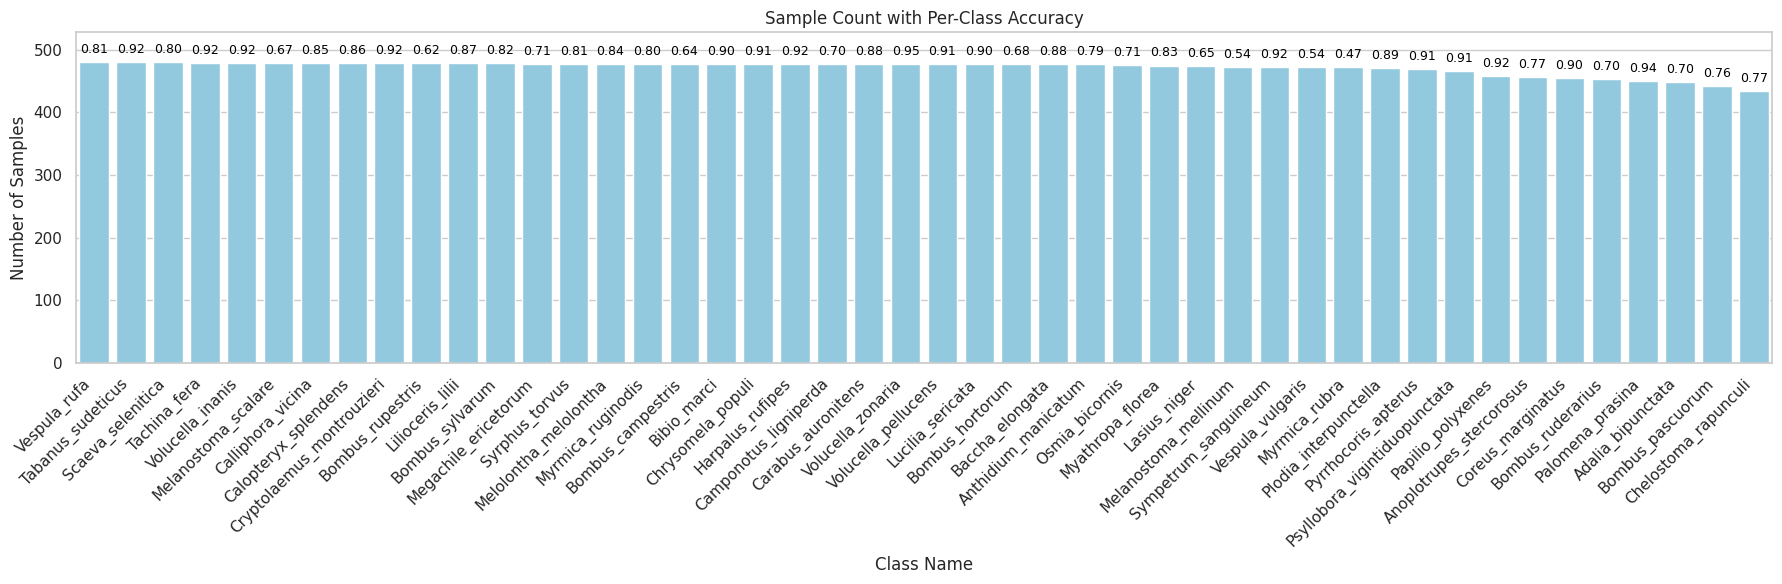

In [50]:
df_sorted = counts_by_classname.sort_values(by="count", ascending=False).iloc[40:-40]
plot_acc_vs_sample_size(df_sorted)